# This notebook is for Analyzing Enron Email Dataset

## Tasks to Do

1. Select emails base on keywords 
    1. Load, Clean & Parse Emails to get started
    2. Select emails based on keywords
2. Time series analysis of the emails
    1. Parse string to Datetime object for doing time series analysis
    2. Plot time series
3. Email Clustering
    1. Rremoving stopwords and vectorize the content
    2. Run KMeans on the Data
    3. Find important keywords from for each clusters
    4. Find topics from the text (??)
4. Sentiment Analysis
    1. Do Sentiment analysis on the email texts
    2. plot sentiments 


#### Importing modules

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans
import re

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import text2emotion as te


from parse_utils import parse_raw_message, parse_into_emails, parse_raw_message
from plot_utils import top_mean_feats, top_feats_per_cluster, plot_tfidf_classfeats_h
plt.rcParams["figure.figsize"] = (20,8) #Setting global parameters for plots


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/facevoid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/facevoid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/facevoid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Reading Data from the directory

In [2]:
project_email_df = pd.read_csv('processed_data/parsed_emails.csv')


#### Parsing Date String to (yyyy-mm-dd hh:mm:ss)

In [3]:
# Sample for parsing
datetime_object = datetime.strptime('Thu, 31 Aug 2000 05', '%a, %d %b %Y %H') 
print(datetime_object)

2000-08-31 05:00:00


In [4]:
def parse_date(row):
    date_str = row['date']
    try:
        datetime_object = datetime.strptime(date_str, '%a, %d %b %Y %H')
    except:
        return None
    return datetime_object

In [5]:
#Parsing dates for all emails
project_email_df['date_converted'] = project_email_df.apply(parse_date, axis = 1)

In [6]:
#Ignore emails that failed in date conversion
project_email_df.dropna(inplace =True)

In [7]:
#Sample of Date Conversion
project_email_df.date_converted = pd.to_datetime(project_email_df.date_converted, errors = 'coerce')
project_email_df['date_converted']

1        2001-05-04 13:00:00
2        2000-10-18 03:00:00
5        2000-08-31 04:00:00
7        2000-10-17 02:00:00
9        2000-10-16 06:00:00
                 ...        
199296   2001-11-28 13:00:00
199297   2001-11-28 12:00:00
199298   2001-11-28 07:00:00
199299   2001-11-27 11:00:00
199300   2001-11-26 10:00:00
Name: date_converted, Length: 177586, dtype: datetime64[ns]

<AxesSubplot:xlabel='date_converted'>

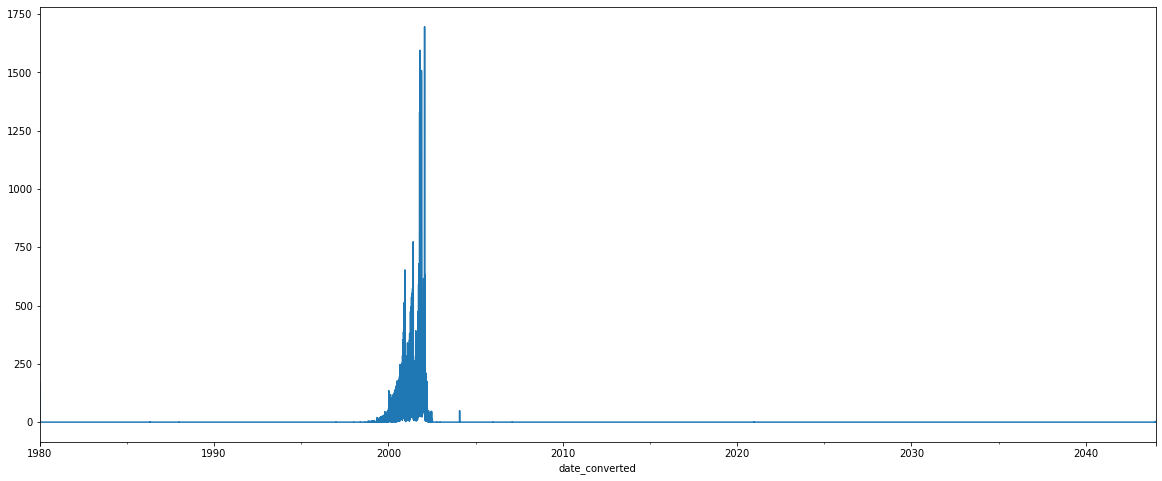

In [8]:
# Email Timelines (change the parameter in the last line to get timeline datewise (D), monthwise (M), yearwise (Y))
plt.rcParams["figure.figsize"] = (20,8)
project_email_df = project_email_df.set_index('date_converted') 
project_email_df.sort_index(inplace = True)
project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

In [9]:
# Select Emails after the year 2000 to get a nice plot
project_email_df['parsed_date'] = project_email_df.index
mask = (project_email_df['parsed_date'] > '2000-01-01') & (project_email_df['parsed_date'] < '2002-04-01')
project_email_df = project_email_df.loc[mask]

<AxesSubplot:xlabel='date_converted'>

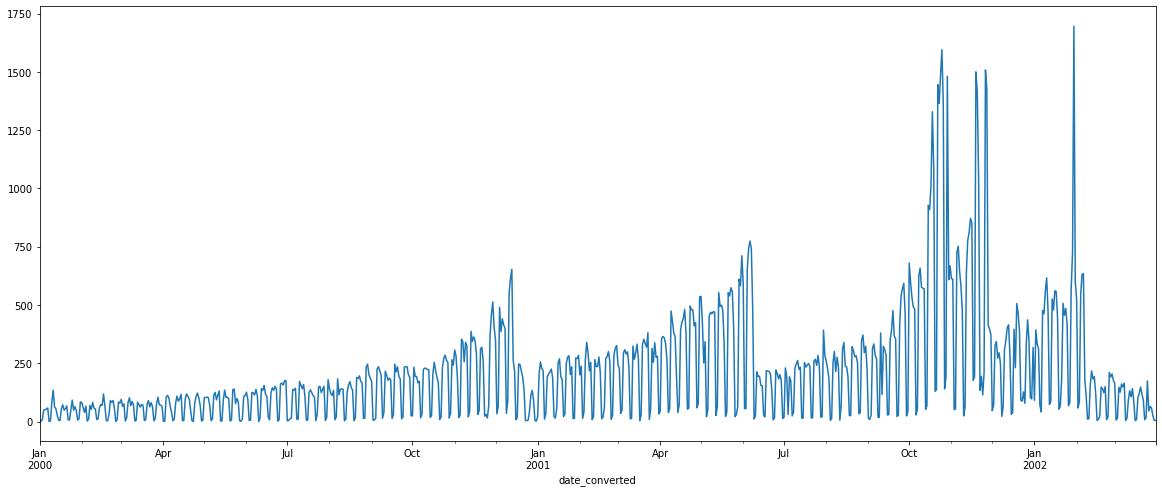

In [10]:

project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

## Cluster Emails 

In [11]:
# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(project_email_df.body)
features = vect.get_feature_names()

In [12]:
n_clusters = 7
batch_size = 500
clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
clf.fit(X)
labels = clf.fit_predict(X)


In [13]:
# plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


## Sentiment Analysis
1. Extracting Aspects [based on POS, can be used ml] , Sentiments & Tones from Texts
2. Create CSV with all extracted information

In [14]:
mask = project_email_df['body'].str.len() < 1000
project_email_filtered_df = project_email_df[mask]

In [15]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_trf')
nlp.add_pipe('spacytextblob')


#### NLTK Sentiment

In [16]:
nltk_sentiment_analyzer = SentimentIntensityAnalyzer()

In [18]:
def get_aspect_based_sentiment_from_spacy(spacy_doc):
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            prepend = ''
            for child in token.children:
                if child.pos_ != 'ADV':
                    continue
                prepend += child.text + ' '
            descriptive_term = prepend + token.text
    return {'nlp_document': doc,
                    'aspect': target,
                    'description': descriptive_term,
                    'doc_polarity': doc._.polarity,
                    'doc_subjectivity': doc._.subjectivity,
                    'doc_entities': doc.ents,
                    'doc': str(doc)
                    }

In [ ]:
sentiments = []
bodies = []
dates = []
spacy_sentiments = []
nltk_sentiments = []

analyzed_texts = []

for index, row in project_email_filtered_df.iterrows():
    
    body = row['body']
    #polarity from spacy and text blob
    doc = nlp(body)
    analyzed_text = get_aspect_based_sentiment_from_spacy(doc)
    
    #NLTK sentiment
    nltk_sentiment = nltk_sentiment_analyzer.polarity_scores(body)
    analyzed_text['nltk_sentiment'] = nltk_sentiment
    #text2emotion
#     analyzed_text['emotion'] = te.get_emotion(body)
    
    analyzed_text['date'] = row['parsed_date']
    
    analyzed_texts.append(analyzed_text)
    

In [ ]:
analyzed_texts_df = pd.DataFrame.from_dict(analyzed_texts)

In [ ]:
analyzed_texts_df

In [ ]:
from spacy import displacy

entities = [ 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']

In [ ]:
for index, row in analyzed_texts_df[:1000].iterrows():

    if len(row['aspect']) > 0 and len(row['description']) > 0:
        if row['doc_polarity'] > 0.3 or row['doc_polarity'] < -0.3:
            print('index ', index)
            for column in analyzed_texts_df.columns:
                if column == 'document':
                    displacy.render(row[column], options = {'ents': entities}, style="ent", )
                    continue
                print(column + ' == > '+ str(row[column]))
            print('\n')

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.plot(dates, sentiments, marker='o', color = 'green' )

plt.xlabel('Time')
plt.ylabel('Sentiment')